In [1]:
from modules import *
%matplotlib widget
datapicker = create_datapicker()
%matplotlib inline
# %matplotlib notebook

### 1. Load dataset

@(WIN) --> \\nas-emotional.fm.ul.pt\eMotional\Exp_4-outdoor_walk\lisbon\sourcedata\data\OE031\Lisbon_Belem_sub-OE101031_2024-05-15T104442Z\20240515124436_OE101031_EXP4.nedf
Reading file...
Header information has been correctly retrieved.
Attempting to automatically correct eeg timestamps to harp timestamps...
Done.
Dataset: <pluma.schema.Dataset object at 0x000001E84D874950> loaded successfully, and sucessfully calibrated.


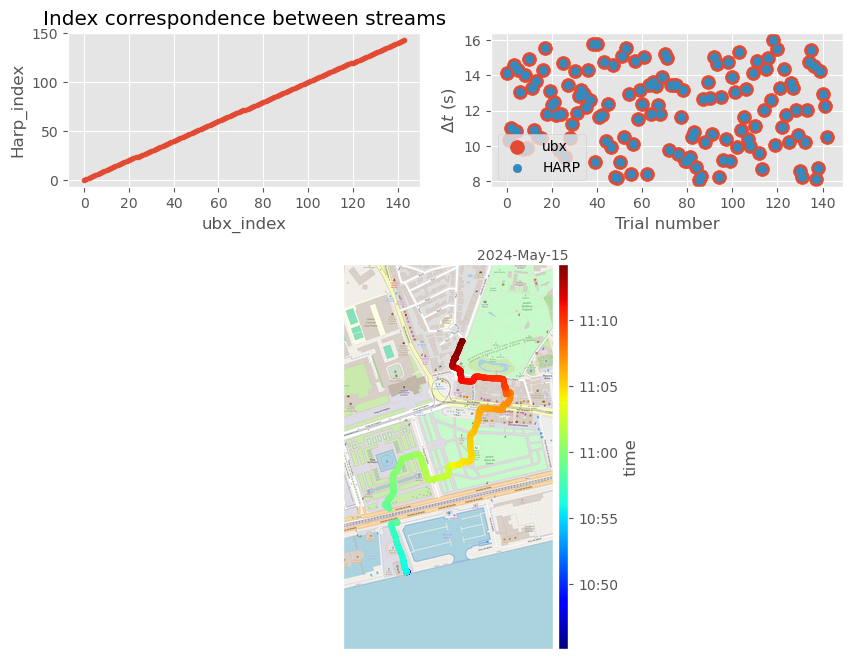

Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.


In [2]:
data_path  = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data\OE031\Lisbon_Belem_sub-OE101031_2024-05-15T104442Z'
datapicker.reset(path = data_path)
create_dataset(datapicker = datapicker)

In [ ]:
# Get participant information from file

import re

# Print the filename
path = str(datapicker.dataset.rootfolder)
path = path.split('\\')
filename = path[-1]
match = re.search(r'1(\d{2})', filename)
if match:
    # The group(1) method returns the matched string
    numbers = match.group(1)
    print(numbers)

#### 1.1. Bidify Datasets 

#### 1.2. Get log data 

In [ ]:
import os
import pandas as pd
from openpyxl import Workbook
from pythermalcomfort.models import utci
import numpy as np
import json

# Initialize the Excel workbook and sheet
wb = Workbook()
ws = wb.active
ws.append(["Participant Name", "Session Name", "Status"])

# Path information
sourcedata = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data'
bidsroot = r'Z:\Exp_4-outdoor_walk\lisbon\bids'

# Save the Excel file
wb.save("session_processing_results.xlsx")

# FUNCTIONS
def process_session(session_path, participant_name, session_name):
    data_path = os.path.join(session_path)
    try:
        datapicker.reset(path=data_path)
        create_dataset(datapicker=datapicker)
        status = "Success"
    except Exception as e:
        status = f"Failed: {str(e)}"
    
    # Log the result
    ws.append([participant_name, session_name, status])
    
    if status == "Success":
        # Generate and bidify the geodata
        geodata = datapicker.geodata # do not use datapicker.geodata()
        create_geodata(geodata)
        bidify_geodata(geodata, participant_name, session_name)

def create_geodata(geodata):
    """Compute UTCI across whole time series."""
    
    # Define custom parameters
    humidity = geodata.tk_humidity_humidity_value / 100  # in fraction
    wind_speed = np.sqrt(geodata.atmos_northwind_value**2 + geodata.atmos_eastwind_value**2)  # m/s (~2.5 m of elevation)
    temp_atmos = geodata.atmos_airtemperature_value  # in ºC
    temp_tk = geodata.tk_airquality_temperature_value / 100  # in ºC
    temp_tk_ptc = geodata.tk_ptc_airtemp_value / 100  # in ºC
    temp_radiant = geodata.tk_thermocouple_temperature_value / 100  # in ºC

    # Assign custom parameters to the geodata attribute
    geodata['humidity'] = humidity
    geodata['wind_speed'] = wind_speed
    geodata['temp_atmos'] = temp_atmos
    geodata['temp_tk'] = temp_tk
    geodata['temp_tk_ptc'] = temp_tk_ptc
    geodata['temp_radiant'] = temp_radiant

    # Compute the UTCI
    geodata['utci'] = utci(tdb=temp_atmos, tr=temp_radiant, v=wind_speed, rh=humidity)

def bidify_geodata(geodata, participant_name, session_name):
    """Create the sessions.tsv file in BIDS format and a sidecar JSON file."""
    
    # Replace missing values with 'n/a'
    geodata = geodata.fillna('n/a')
    
    # Prepare the sessions.tsv DataFrame
    sessions_df = pd.DataFrame({
        'session_id': [f"ses-{session_name}"],
        'acq_time': [geodata['time'].iloc[0]],  # Use the first value in the 'time' column for acq_time
    })

    # Include all other columns from geodata in the sessions_df
    additional_columns = geodata.iloc[0].to_dict()  # Take the first row as the representative for additional columns
    sessions_df = sessions_df.assign(**additional_columns)

    # Define the BIDS folder path
    bids_folder = os.path.join(bidsroot, f"sub-{participant_name}")
    os.makedirs(bids_folder, exist_ok=True)

    # Save the sessions.tsv file
    sessions_file = os.path.join(bids_folder, 'sessions.tsv')
    sessions_df.to_csv(sessions_file, sep='\t', index=False)

    # Create the sidecar JSON file
    create_sessions_json(bids_folder)

def create_sessions_json(bids_folder):
    """Create the sessions.json file with descriptions for each column."""
    
    sidecar_description = {
        "session_id": "A session identifier representing the name of the path.",
        "acq_time": "Acquisition time of the first data point in the session.",
        "time": "Timestamp of each recorded data point in the session, representing the exact time when the measurement was taken.",
        "tk_gps_data_value": "GPS data value, likely representing latitude, longitude, or altitude information collected from the GPS sensor.",
        "tk_gps_time_value": "Timestamp from the GPS sensor, providing the exact time the GPS data was recorded.",
        "tk_airquality_iaqindex_value": "Indoor Air Quality (IAQ) index value, representing the overall air quality based on multiple environmental factors.",
        "tk_airquality_temperature_value": "Temperature reading from the air quality sensor, provided in raw format before conversion to degrees Celsius (°C).",
        "tk_airquality_humidity_value": "Relative humidity as recorded by the air quality sensor, expressed as a percentage.",
        "tk_airquality_airpressure_value": "Air pressure reading from the air quality sensor, measured in hectopascals (hPa).",
        "tk_soundpressurelevel_spl_value": "Sound Pressure Level (SPL) value measured in decibels (dB), indicating the intensity of sound in the environment.",
        "tk_humidity_humidity_value": "Humidity level measured by the TK sensor, expressed as a percentage.",
        "tk_analogin_voltage_value": "Analog input voltage value, possibly representing a sensor's electrical output in volts.",
        "tk_particulatematter_pm1_0_value": "Concentration of particulate matter (PM1.0) in the air, measured in micrograms per cubic meter (µg/m³).",
        "tk_particulatematter_pm2_5_value": "Concentration of particulate matter (PM2.5) in the air, measured in micrograms per cubic meter (µg/m³).",
        "tk_particulatematter_pm10_0_value": "Concentration of particulate matter (PM10) in the air, measured in micrograms per cubic meter (µg/m³).",
        "tk_dual0_20ma_solarlight_value": "Solar light intensity value, measured in raw sensor output (possibly milliamps or another unit related to solar radiation).",
        "tk_thermocouple_temperature_value": "Raw temperature reading from the thermocouple sensor, before conversion to degrees Celsius (°C).",
        "tk_ptc_airtemp_value": "Temperature measured by the Positive Temperature Coefficient (PTC) sensor, in degrees Celsius (°C).",
        "atmos_northwind_value": "Wind speed component in the northward direction, measured in meters per second (m/s).",
        "atmos_eastwind_value": "Wind speed component in the eastward direction, measured in meters per second (m/s).",
        "atmos_gustwind_value": "Maximum wind gust speed recorded during the session, measured in meters per second (m/s).",
        "atmos_airtemperature_value": "Atmospheric temperature during the session, measured in degrees Celsius (°C).",
        "atmos_xorientation_value": "Orientation value in the X-axis, representing the angle of the sensor in the horizontal plane.",
        "atmos_yorientation_value": "Orientation value in the Y-axis, representing the angle of the sensor in the vertical plane.",
        "atmos_nullvalue_value": "A placeholder or null value, typically used to indicate the absence of valid data.",
        "accelerometer_orientation_x": "Orientation value along the X-axis recorded by the accelerometer, representing the tilt or angle of the sensor.",
        "accelerometer_orientation_y": "Orientation value along the Y-axis recorded by the accelerometer, representing the tilt or angle of the sensor.",
        "accelerometer_orientation_z": "Orientation value along the Z-axis recorded by the accelerometer, representing the tilt or angle of the sensor.",
        "accelerometer_gyroscope_x": "Angular velocity around the X-axis recorded by the gyroscope, measured in degrees per second (°/s).",
        "accelerometer_gyroscope_y": "Angular velocity around the Y-axis recorded by the gyroscope, measured in degrees per second (°/s).",
        "accelerometer_gyroscope_z": "Angular velocity around the Z-axis recorded by the gyroscope, measured in degrees per second (°/s).",
        "accelerometer_linearaccl_x": "Linear acceleration along the X-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_linearaccl_y": "Linear acceleration along the Y-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_linearaccl_z": "Linear acceleration along the Z-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_magnetometer_x": "Magnetic field strength along the X-axis recorded by the magnetometer, measured in microteslas (µT).",
        "accelerometer_magnetometer_y": "Magnetic field strength along the Y-axis recorded by the magnetometer, measured in microteslas (µT).",
        "accelerometer_magnetometer_z": "Magnetic field strength along the Z-axis recorded by the magnetometer, measured in microteslas (µT).",
        "accelerometer_accl_x": "Acceleration along the X-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_accl_y": "Acceleration along the Y-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_accl_z": "Acceleration along the Z-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_gravity_x": "Gravity component along the X-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_gravity_y": "Gravity component along the Y-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "accelerometer_gravity_z": "Gravity component along the Z-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
        "humidity": "Humidity level during the session, measured as a percentage relative to the maximum amount of moisture air can hold at the given temperature.",
        "wind_speed": "Calculated wind speed considering both northward and eastward components, measured in meters per second (m/s).",
        "temp_atmos": "Atmospheric temperature during the session, measured in degrees Celsius (°C).",
        "temp_tk": "Temperature measured by the TK sensor, converted to degrees Celsius (°C).",
        "temp_tk_ptc": "Temperature measured by the Positive Temperature Coefficient (PTC) sensor, in degrees Celsius (°C).",
        "temp_radiant": "Radiant temperature measured by the thermocouple sensor, in degrees Celsius (°C).",
        "utci": "Universal Thermal Climate Index calculated during the session, which is a measure of the perceived temperature accounting for the effects of wind, humidity, and radiant heat on the human body.",
        "x": "Coordinate or value related to the X-axis in a 3D spatial context.",
        "y": "Coordinate or value related to the Y-axis in a 3D spatial context.",
        "z": "Coordinate or value related to the Z-axis in a 3D spatial context."
    }

    sidecar_file = os.path.join(bids_folder, 'sessions.json')
    with open(sidecar_file, 'w') as json_file:
        json.dump(sidecar_description, json_file, indent=4)

# MAIN SCRIPT

# Replace 'OE031' with the specific participant folder you want to test
participant_folder = 'OE011'
participant_path = os.path.join(sourcedata, participant_folder)

for session_folder in os.listdir(participant_path):
    session_path = os.path.join(participant_path, session_folder)
    if os.path.isdir(session_path):
        process_session(session_path, participant_folder, session_folder)

# Save the Excel file with the updated status
wb.save("session_processing_results.xlsx")


In [ ]:
# JSON file with descriptions for each column

{        
    "session_id": "A session identifier representing the name of the path.",
    "acq_time": "Acquisition time of the first data point in the session.",
    "time": "Timestamp of each recorded data point in the session, representing the exact time when the measurement was taken.",
    "tk_gps_data_value": "GPS data value, likely representing latitude, longitude, or altitude information collected from the GPS sensor.",
    "tk_gps_time_value": "Timestamp from the GPS sensor, providing the exact time the GPS data was recorded.",
    "tk_airquality_iaqindex_value": "Indoor Air Quality (IAQ) index value, representing the overall air quality based on multiple environmental factors.",
    "tk_airquality_temperature_value": "Temperature reading from the air quality sensor, provided in raw format before conversion to degrees Celsius (°C).",
    "tk_airquality_humidity_value": "Relative humidity as recorded by the air quality sensor, expressed as a percentage.",
    "tk_airquality_airpressure_value": "Air pressure reading from the air quality sensor, measured in hectopascals (hPa).",
    "tk_soundpressurelevel_spl_value": "Sound Pressure Level (SPL) value measured in decibels (dB), indicating the intensity of sound in the environment.",
    "tk_humidity_humidity_value": "Humidity level measured by the TK sensor, expressed as a percentage.",
    "tk_analogin_voltage_value": "Analog input voltage value, possibly representing a sensor's electrical output in volts.",
    "tk_particulatematter_pm1_0_value": "Concentration of particulate matter (PM1.0) in the air, measured in micrograms per cubic meter (µg/m³).",
    "tk_particulatematter_pm2_5_value": "Concentration of particulate matter (PM2.5) in the air, measured in micrograms per cubic meter (µg/m³).",
    "tk_particulatematter_pm10_0_value": "Concentration of particulate matter (PM10) in the air, measured in micrograms per cubic meter (µg/m³).",
    "tk_dual0_20ma_solarlight_value": "Solar light intensity value, measured in raw sensor output (possibly milliamps or another unit related to solar radiation).",
    "tk_thermocouple_temperature_value": "Raw temperature reading from the thermocouple sensor, before conversion to degrees Celsius (°C).",
    "tk_ptc_airtemp_value": "Temperature measured by the Positive Temperature Coefficient (PTC) sensor, in degrees Celsius (°C).",
    "atmos_northwind_value": "Wind speed component in the northward direction, measured in meters per second (m/s).",
    "atmos_eastwind_value": "Wind speed component in the eastward direction, measured in meters per second (m/s).",
    "atmos_gustwind_value": "Maximum wind gust speed recorded during the session, measured in meters per second (m/s).",
    "atmos_airtemperature_value": "Atmospheric temperature during the session, measured in degrees Celsius (°C).",
    "atmos_xorientation_value": "Orientation value in the X-axis, representing the angle of the sensor in the horizontal plane.",
    "atmos_yorientation_value": "Orientation value in the Y-axis, representing the angle of the sensor in the vertical plane.",
    "atmos_nullvalue_value": "A placeholder or null value, typically used to indicate the absence of valid data.",
    "accelerometer_orientation_x": "Orientation value along the X-axis recorded by the accelerometer, representing the tilt or angle of the sensor.",
    "accelerometer_orientation_y": "Orientation value along the Y-axis recorded by the accelerometer, representing the tilt or angle of the sensor.",
    "accelerometer_orientation_z": "Orientation value along the Z-axis recorded by the accelerometer, representing the tilt or angle of the sensor.",
    "accelerometer_gyroscope_x": "Angular velocity around the X-axis recorded by the gyroscope, measured in degrees per second (°/s).",
    "accelerometer_gyroscope_y": "Angular velocity around the Y-axis recorded by the gyroscope, measured in degrees per second (°/s).",
    "accelerometer_gyroscope_z": "Angular velocity around the Z-axis recorded by the gyroscope, measured in degrees per second (°/s).",
    "accelerometer_linearaccl_x": "Linear acceleration along the X-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_linearaccl_y": "Linear acceleration along the Y-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_linearaccl_z": "Linear acceleration along the Z-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_magnetometer_x": "Magnetic field strength along the X-axis recorded by the magnetometer, measured in microteslas (µT).",
    "accelerometer_magnetometer_y": "Magnetic field strength along the Y-axis recorded by the magnetometer, measured in microteslas (µT).",
    "accelerometer_magnetometer_z": "Magnetic field strength along the Z-axis recorded by the magnetometer, measured in microteslas (µT).",
    "accelerometer_accl_x": "Acceleration along the X-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_accl_y": "Acceleration along the Y-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_accl_z": "Acceleration along the Z-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_gravity_x": "Gravity component along the X-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_gravity_y": "Gravity component along the Y-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "accelerometer_gravity_z": "Gravity component along the Z-axis recorded by the accelerometer, measured in meters per second squared (m/s²).",
    "humidity": "Humidity level during the session, measured as a percentage relative to the maximum amount of moisture air can hold at the given temperature.",
    "wind_speed": "Calculated wind speed considering both northward and eastward components, measured in meters per second (m/s).",
    "temp_atmos": "Atmospheric temperature during the session, measured in degrees Celsius (°C).",
    "temp_tk": "Temperature measured by the TK sensor, converted to degrees Celsius (°C).",
    "temp_tk_ptc": "Temperature measured by the Positive Temperature Coefficient (PTC) sensor, in degrees Celsius (°C).",
    "temp_radiant": "Radiant temperature measured by the thermocouple sensor, in degrees Celsius (°C).",
    "utci": "Universal Thermal Climate Index calculated during the session, which is a measure of the perceived temperature accounting for the effects of wind, humidity, and radiant heat on the human body.",
    "x": "Coordinate or value related to the X-axis in a 3D spatial context.",
    "y": "Coordinate or value related to the Y-axis in a 3D spatial context.",
    "z": "Coordinate or value related to the Z-axis in a 3D spatial context."
}


In [13]:
datapicker = create_datapicker()


# Full loop and test 

@(WIN) --> \\nas-emotional.fm.ul.pt\eMotional\Exp_4-outdoor_walk\lisbon\sourcedata\data\OE001\Lisbon_Parque_sub-OE106001_2024-05-27T103525Z\20240527113511_OE106001_EXP4.nedf
Reading file...
Header information has been correctly retrieved.
Attempting to automatically correct eeg timestamps to harp timestamps...
Done.
Dataset: <pluma.schema.Dataset object at 0x00000290A35449E0> loaded successfully, and sucessfully calibrated.


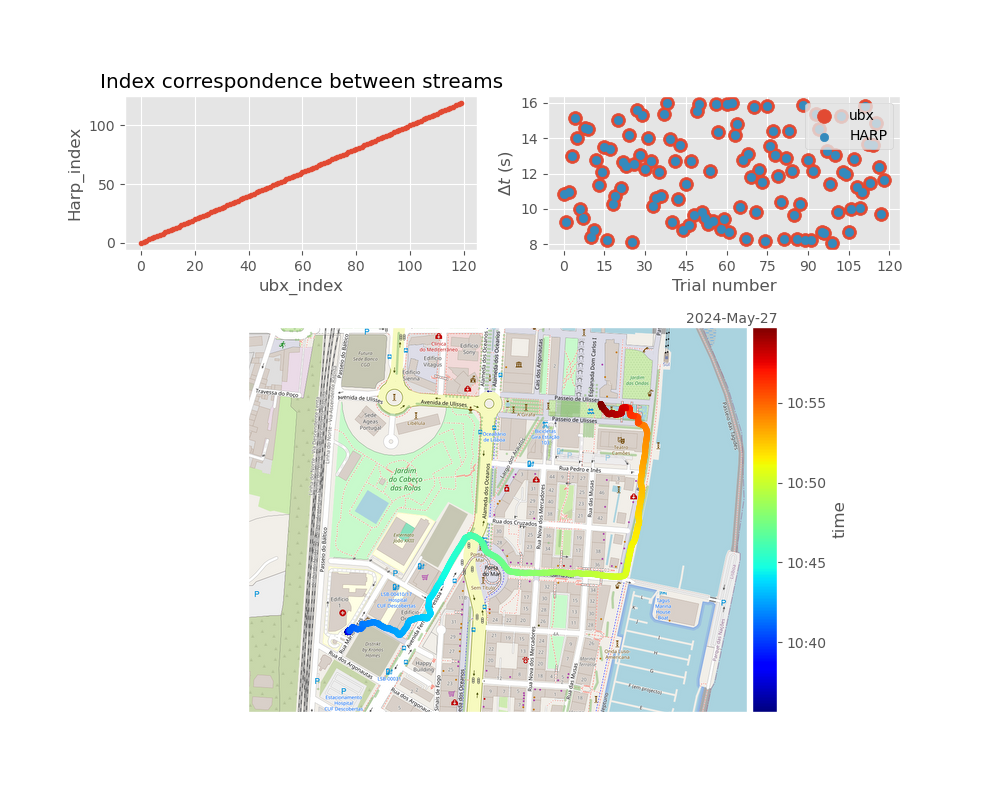

Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.


TypeError: 'GeoDataFrame' object is not callable

In [ ]:
import os
import pandas as pd
from openpyxl import Workbook
from pythermalcomfort.models import utci
import numpy as np

# ---------------------------------------------------------------------
# Initialize the Excel workbook and sheet
wb = Workbook()
ws = wb.active
ws.append(["Participant Name", "Session Name", "Status", "Radiant Temperature"])

# Path information
sourcedata = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data'
logdata    = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log'

# ---------------------------------------------------------------------
# FUNCTIONS
def process_session(session_path, participant_name, session_name):
    data_path = os.path.join(session_path)
    try:
        datapicker.reset(path=data_path)
        create_dataset(datapicker=datapicker)
        status = 1  # Success
    except Exception as e:
        status = 0  # Failed
    
    radiant_temp_status = 0  # Default to 0 if not found or if all zeros

    if status == 1:
        # Generate the sessions.tsv file
        geodata = datapicker.geodata  # Retrieve geodata
        create_geodata(geodata)

        # Get GPS coordinates and integrate them into geodata
        coords = datapicker.geodata.geometry.get_coordinates(include_z=True)
        # Optionally rename the coordinate columns
        coords.rename(columns={'y': 'latitude', 'x': 'longitude', 'z': 'elevation'}, inplace=True)
        geodata = geodata.join(coords).drop(columns=['geometry'])

        # Check if the radiant temperature column exists and contains non-zero values
        if 'tk_thermocouple_temperature_value' in geodata:
            if geodata['tk_thermocouple_temperature_value'].sum() != 0:
                radiant_temp_status = 1  # Non-zero values exist

        # Save the full geodata to an Excel file in the log directory
        log_folder = os.path.join(logdata, f"sub-{participant_name}", f"ses-{session_name}")
        os.makedirs(log_folder, exist_ok=True)
        geodata_file = os.path.join(log_folder, f"sub-{participant_name}_ses-{session_name}_geodata.xlsx")
        
        # Convert geodata to DataFrame if it's not already and save as Excel
        if not isinstance(geodata, pd.DataFrame):
            geodata = pd.DataFrame(geodata)
        geodata.to_excel(geodata_file, index=False)
    
    # Log the result
    ws.append([participant_name, session_name, status, radiant_temp_status])

def create_geodata(geodata):
    """Compute UTCI across whole time series."""
    
    # Define custom parameters
    humidity = geodata['tk_humidity_humidity_value'] / 100  # in fraction
    wind_speed = np.sqrt(geodata['atmos_northwind_value']**2 + geodata['atmos_eastwind_value']**2)  # m/s (~2.5 m of elevation)
    temp_atmos = geodata['atmos_airtemperature_value']  # in ºC
    temp_tk = geodata['tk_airquality_temperature_value'] / 100  # in ºC
    temp_tk_ptc = geodata['tk_ptc_airtemp_value'] / 100  # in ºC
    temp_radiant = geodata['tk_thermocouple_temperature_value'] / 100  # in ºC

    # Assign custom parameters to the geodata attribute
    geodata['humidity'] = humidity
    geodata['wind_speed'] = wind_speed
    geodata['temp_atmos'] = temp_atmos
    geodata['temp_tk'] = temp_tk
    geodata['temp_tk_ptc'] = temp_tk_ptc
    geodata['temp_radiant'] = temp_radiant

    # Compute the UTCI
    geodata['utci'] = utci(tdb=temp_atmos, tr=temp_radiant, v=wind_speed, rh=humidity)

# ---------------------------------------------------------------------
# MAIN SCRIPT
for participant_folder in os.listdir(sourcedata):
    if participant_folder.startswith("OE"):
        participant_path = os.path.join(sourcedata, participant_folder)
        for session_folder in os.listdir(participant_path):
            session_path = os.path.join(participant_path, session_folder)
            if os.path.isdir(session_path):
                process_session(session_path, participant_folder, session_folder)

# Save the Excel file with the updated status in the log directory
result_file = os.path.join(logdata, "session_processing_results.xlsx")
wb.save(result_file)

In [5]:
import os
import pandas as pd
from openpyxl import Workbook
from pythermalcomfort.models import utci
import numpy as np

# ---------------------------------------------------------------------
# Initialize the Excel workbook and sheet
wb = Workbook()
ws = wb.active
ws.append(["Participant Name", "Session Name", "Status", "Radiant Temperature"])

# Path information
sourcedata = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data'
logdata    = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log'

# ---------------------------------------------------------------------
# FUNCTIONS
def process_session(session_path, participant_name, session_name):
    data_path = os.path.join(session_path)
    try:
        datapicker.reset(path=data_path)
        create_dataset(datapicker=datapicker)
        status = 1  # Success
    except Exception as e:
        status = 0  # Failed
    
    radiant_temp_status = 0  # Default to 0 if not found or if all zeros

    if status == 1:
        # Generate the sessions.tsv file
        geodata = datapicker.geodata  # Retrieve geodata
        create_geodata(geodata)

        # Get GPS coordinates and integrate them into geodata
        coords = datapicker.geodata.geometry.get_coordinates(include_z=True)
        # Optionally rename the coordinate columns
        coords.rename(columns={'y': 'latitude', 'x': 'longitude', 'z': 'elevation'}, inplace=True)
        geodata = geodata.join(coords).drop(columns=['geometry'])

        # Check if the radiant temperature column exists and contains non-zero values
        if 'tk_thermocouple_temperature_value' in geodata:
            if geodata['tk_thermocouple_temperature_value'].sum() != 0:
                radiant_temp_status = 1  # Non-zero values exist

        # Save the full geodata to an Excel file in the log directory
        log_folder = os.path.join(logdata, f"sub-{participant_name}", f"ses-{session_name}")
        os.makedirs(log_folder, exist_ok=True)
        geodata_file = os.path.join(log_folder, f"sub-{participant_name}_ses-{session_name}_geodata.xlsx")
        
        # Convert geodata to DataFrame if it's not already and save as Excel
        if not isinstance(geodata, pd.DataFrame):
            geodata = pd.DataFrame(geodata)
        geodata.to_excel(geodata_file, index=True)
    
    # Log the result
    ws.append([participant_name, session_name, status, radiant_temp_status])

def create_geodata(geodata):
    """Compute UTCI across whole time series."""
    
    # Define custom parameters
    humidity = geodata['tk_humidity_humidity_value'] / 100  # in fraction
    wind_speed = np.sqrt(geodata['atmos_northwind_value']**2 + geodata['atmos_eastwind_value']**2)  # m/s (~2.5 m of elevation)
    temp_atmos = geodata['atmos_airtemperature_value']  # in ºC
    temp_tk = geodata['tk_airquality_temperature_value'] / 100  # in ºC
    temp_tk_ptc = geodata['tk_ptc_airtemp_value'] / 100  # in ºC
    temp_radiant = geodata['tk_thermocouple_temperature_value'] / 100  # in ºC

    # Assign custom parameters to the geodata attribute
    geodata['humidity'] = humidity
    geodata['wind_speed'] = wind_speed
    geodata['temp_atmos'] = temp_atmos
    geodata['temp_tk'] = temp_tk
    geodata['temp_tk_ptc'] = temp_tk_ptc
    geodata['temp_radiant'] = temp_radiant

    # Compute the UTCI
    geodata['utci'] = utci(tdb=temp_atmos, tr=temp_radiant, v=wind_speed, rh=humidity)

# ---------------------------------------------------------------------
# MAIN SCRIPT
processed_participants = 0

for participant_folder in os.listdir(sourcedata):
    if participant_folder.startswith("OE"):
        participant_path = os.path.join(sourcedata, participant_folder)
        for session_folder in os.listdir(participant_path):
            session_path = os.path.join(participant_path, session_folder)
            if os.path.isdir(session_path):
                process_session(session_path, participant_folder, session_folder)

        processed_participants += 1
        if processed_participants >= 43:
            break  # Stop after processing 2 participants

# Save the Excel file with the updated status in the log directory
result_file = os.path.join(logdata, "session_processing_results.xlsx")
wb.save(result_file)


## full LOOP

In [1]:
import os
import pandas as pd
from openpyxl import Workbook
from pythermalcomfort.models import utci
import numpy as np

# ---------------------------------------------------------------------
# Initialize the Excel workbook and sheet
wb = Workbook()
ws = wb.active
ws.append(["Participant Name", "Session Name", "Status", "Radiant Temperature"])

# Path information
sourcedata = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data'
logdata    = r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\supp\log'

# To store the mean values for each session
all_means = []

# ---------------------------------------------------------------------
# FUNCTIONS
def process_session(session_path, participant_name, session_name):
    global all_means  # Declare all_means as global
    data_path = os.path.join(session_path)
    try:
        datapicker.reset(path=data_path)
        create_dataset(datapicker=datapicker)
        status = 1  # Success
    except Exception as e:
        status = 0  # Failed
    
    radiant_temp_status = 0  # Default to 0 if not found or if all zeros

    if status == 1:
        # Generate the sessions.tsv file
        geodata = datapicker.geodata  # Retrieve geodata
        create_geodata(geodata)

        # Get GPS coordinates and integrate them into geodata
        coords = datapicker.geodata.geometry.get_coordinates(include_z=True)
        coords.rename(columns={'y': 'latitude', 'x': 'longitude', 'z': 'elevation'}, inplace=True)
        geodata = geodata.join(coords).drop(columns=['geometry'])

        # Check if the radiant temperature column exists and contains non-zero values
        if 'tk_thermocouple_temperature_value' in geodata:
            if geodata['tk_thermocouple_temperature_value'].sum() != 0:
                radiant_temp_status = 1  # Non-zero values exist

        # Save the full geodata to an Excel file in the log directory
        log_folder = os.path.join(logdata, f"sub-{participant_name}", f"ses-{session_name}")
        os.makedirs(log_folder, exist_ok=True)
        geodata_file = os.path.join(log_folder, f"sub-{participant_name}_ses-{session_name}_geodata.xlsx")
        geodata.to_excel(geodata_file, index=False)

        # Compute the mean of all numerical columns
        numeric_means = geodata.mean(numeric_only=True).to_dict()
        numeric_means['Participant'] = participant_name
        numeric_means['Session'] = session_name
        all_means.append(numeric_means)  # Append to the global all_means list
    
    # Log the result
    ws.append([participant_name, session_name, status, radiant_temp_status])


def create_geodata(geodata):
    """Compute UTCI across the whole time series."""
    
    # Define custom parameters
    humidity = geodata['tk_humidity_humidity_value'] / 100  # in fraction
    wind_speed = np.sqrt(geodata['atmos_northwind_value']**2 + geodata['atmos_eastwind_value']**2)  # m/s (~2.5 m of elevation)
    temp_atmos = geodata['atmos_airtemperature_value']  # in ºC
    temp_tk = geodata['tk_airquality_temperature_value'] / 100  # in ºC
    temp_tk_ptc = geodata['tk_ptc_airtemp_value'] / 100  # in ºC
    temp_radiant = geodata['tk_thermocouple_temperature_value'] / 100  # in ºC

    # Assign custom parameters to the geodata attribute
    geodata['humidity'] = humidity
    geodata['wind_speed'] = wind_speed
    geodata['temp_atmos'] = temp_atmos
    geodata['temp_tk'] = temp_tk
    geodata['temp_tk_ptc'] = temp_tk_ptc
    geodata['temp_radiant'] = temp_radiant

    # Compute the UTCI
    geodata['utci'] = utci(tdb=temp_atmos, tr=temp_radiant, v=wind_speed, rh=humidity)

# ---------------------------------------------------------------------
# MAIN SCRIPT
processed_participants = 0

for participant_folder in os.listdir(sourcedata):
    if participant_folder.startswith("OE"):
        participant_path = os.path.join(sourcedata, participant_folder)
        for session_folder in os.listdir(participant_path):
            session_path = os.path.join(participant_path, session_folder)
            if os.path.isdir(session_path):
                process_session(session_path, participant_folder, session_folder)

        processed_participants += 1
        if processed_participants >= 2:
            break  # Stop after processing 2 participants

# Save the Excel file with the updated status in the log directory
result_file = os.path.join(logdata, "session_processing_results.xlsx")
wb.save(result_file)

# Save the mean values to a final CSV file
if all_means:
    final_means_df = pd.DataFrame(all_means)
    final_means_file = os.path.join(logdata, "final_means.csv")
    final_means_df.to_csv(final_means_file, index=False)
    print(f"Final CSV file with mean values saved to: {final_means_file}")
else:
    print("No valid data found to compute mean values.")


No valid data found to compute mean values.


### 2. Explore Dataset Maps

In [ ]:
# datapicker.geodata
"""Assess datapicker geodata information

"""
import pprint

geo_data = datapicker.geodata.columns
pprint.pprint(geo_data)

streams_data = datapicker.dataset.streams
pprint.pprint(dir(streams_data))

tk_data = datapicker.dataset.streams.PupilLabs.Counter.Gaze
pprint.pprint(dir(tk_data))

#### 2.1. Create new variables

In [ ]:
"""Compute UTCI across whole time series
- pip install pythermalcomfort
- See docs (https://pypi.org/project/pythermalcomfort/)
UTCI:
The parameters that are taken into account for calculating UTCI involve dry bulb temperature, mean radiation temperature, the pressure of water vapor or relative humidity, and wind speed (at the elevation of 10 m above the ground).
"""
import pandas as pd
from pythermalcomfort.models import utci

# Define custom parameters
humidity = datapicker.geodata.tk_humidity_humidity_value / 100 # in % or fraction?
wind_speed = np.sqrt(datapicker.geodata.atmos_northwind_value**2 + datapicker.geodata.atmos_eastwind_value**2) # m/s (~2.5 m of elevation)
temp_atmos= datapicker.geodata.atmos_airtemperature_value # in ºC
temp_tk = datapicker.geodata.tk_airquality_temperature_value/100 # in ºC)
temp_tk_ptc = datapicker.geodata.tk_ptc_airtemp_value/100 # positive temperature coefficient (in ºC
temp_radiant = datapicker.geodata.tk_thermocouple_temperature_value/100 # in ºC

# Assign custom parameters to the geodata attribute
datapicker.geodata['humidity'] = humidity
datapicker.geodata['wind_speed'] = wind_speed
datapicker.geodata['temp_atmos'] = temp_atmos
datapicker.geodata['temp_tk'] = temp_tk
datapicker.geodata['temp_tk_ptc'] = temp_tk_ptc
datapicker.geodata['temp_radiant'] = temp_radiant

# Compute the UTCI
utci = utci(tdb=temp_atmos, tr=temp_radiant, v=wind_speed, rh=humidity)
datapicker.geodata['utci'] = utci

In [ ]:
"""interpret variables
- utci
    - See [here](Explicacao utci https://climate-adapt.eea.europa.eu/en/metadata/indicators/thermal-comfort-indices-universal-thermal-climate-index-1979-2019)
"""
exploremap(datapicker.geodata, column = 'tk_gps_data_value', cmap = 'hot')

In [ ]:
exploremap(datapicker.geodata)

#### 2.2. Get geojson file for maps

In [ ]:
numbers = '03'

In [ ]:
import geopandas as gpd
import os

def find_file(number):
    root = "G:\\Shared drives\\Shared_FMUL_eMC\\WP5\\4_OutdoorExperiment\\LisbonWalks\\Useful Documents\\exp4percursos\\geojson_files"

    if number == '01':
        filename = [file for file in os.listdir(root) if 'belem' in file][0]
    elif number == '02':
        filename = [file for file in os.listdir(root) if 'lapa' in file][0]
    elif number == '03':
        filename = [file for file in os.listdir(root) if 'anovas' in file][0]
    elif number == '04':
        filename = [file for file in os.listdir(root) if 'baixa' in file][0]
    elif number == '05':
        filename = [file for file in os.listdir(root) if 'graca' in file][0]
    elif number == '06':
        filename = [file for file in os.listdir(root) if 'pnacoes' in file][0]
    else:
        return "Invalid number"

    filepath = os.path.join(root, filename)
    
    if os.path.isfile(filepath):
        return filepath
    else:
        return "File not found"

print(find_file(str(numbers)))  

In [ ]:
# Check ideal path (customize for path)

import folium
import numpy as np

# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(find_file(str(numbers)))

# Calculate the mean latitude and longitude
mean_lat = np.mean(gdf.geometry[0].coords.xy[1])
mean_lon = np.mean(gdf.geometry[0].coords.xy[0])

# Create a map centered at the mean of the coordinates in the LineString
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

# Add the LineString to the map
folium.GeoJson(gdf.geometry[0]).add_to(m)

# Show the map
m

#### 2.3. Visualize maps

In [ ]:
"""exploremap kwargs
- see (here)[https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html]
- common cmaps:
    - 'viridis'
    - 'plasma'
    - 'inferno'
    - 'magma'
    - 'cividis'
    - 'hot'
    - 'cool'
    - 'spring'
"""

map = exploremap(datapicker.geodata, cmap = 'spring')
folium.GeoJson(gdf.geometry[0]).add_to(map)
map # Display the map (can be exported to html if necessary)

### 3. Explore Dataset Streams (without EEG)

In [ ]:
revts = datapicker.dataset.streams.EEG.server_lsl_marker
evts = revts[revts.MarkerIdx>35000]
print(evts)# Type -> <class 'pandas.core.frame.DataFrame'>
if len(evts[evts.MarkerIdx<35099])>4: # Check if acquisition has baseline
    baseline=True
else:
    baseline=False
print(baseline)
# ---------------------------------------------------------------
revts = datapicker.dataset.streams.EEG.server_lsl_marker
evts = revts[revts.MarkerIdx>35000]
if baseline:
    # Automatically pass checkpoints to the plot_traces function
    beg_bs_close = evts[evts.MarkerIdx==35001].index[0]
    end_bs_close = evts[evts.MarkerIdx==35002].index[0]
    beg_bs_open = evts[evts.MarkerIdx==35003].index[0]
    end_bs_open = evts[evts.MarkerIdx==35004].index[0]
    beg = evts[evts.MarkerIdx==35005].index[0]
    end = evts[evts.MarkerIdx==35006].index[0]
    beg_bs_close_seconds = evts.loc[beg_bs_close, 'Seconds']
    end_bs_close_seconds = evts.loc[end_bs_close, 'Seconds']
    beg_bs_open_seconds = evts.loc[beg_bs_open, 'Seconds']
    end_bs_open_seconds = evts.loc[end_bs_open, 'Seconds']
    beg_seconds = evts.loc[beg, 'Seconds']
    end_seconds = evts.loc[end, 'Seconds']

    evts = evts[evts.MarkerIdx>35099] # Remove the markers ids < 35099
    indexes = evts[(evts.MarkerIdx //100) % 10 == 1].index # Get the indexes of the markers
    sub_dfs = [evts.loc[indexes[i]:indexes[i+1]-1] for i in range(len(indexes)-1)] # Divide the DataFrame by the indexes
    sub_dfs.append(evts.loc[indexes[-1]:])  # Add the last segment from the last index to the end of the DataFrame

    chk_segments = []
    list_dict = {1: [1, 0.1, 0.1], 2: [0.1, 1, 0.1], 3: [0.1, 0.1, 0.1]} # Red, Green, Black

    for df in sub_dfs:
        for i in range(1, 4):
            index = df[(df.MarkerIdx // 100) % 10 == i].first_valid_index()
            if index is not None:
                chk_segments.append((df.loc[index, 'Seconds'], list_dict[i]))

    # Prepend beg and append end to chk_segments
    chk_segments.insert(0, (beg_bs_close_seconds, [128/255, 0, 128/255])) # Purple color to eyes closed baseline
    chk_segments.insert(1, (end_bs_close_seconds, [1, 1, 1])) # White color to end
    chk_segments.insert(2, (beg_bs_open_seconds, [0.1, 0.1, 1])) # Blue color to eyes open baseline
    chk_segments.insert(3, (end_bs_open_seconds, [1, 1, 1])) # White color to end
    chk_segments.insert(4, (beg_seconds, [0.1, 0.1, 0.1])) # Black color to beginning
    chk_segments.append((end_seconds, [0.1, 0.1, 0.1])) # Black color to end
    
else:
    first = evts.loc[evts.index[0], 'Seconds']
    beg = evts[evts.MarkerIdx==35001].index[0]
    end = evts[evts.MarkerIdx==35002].index[0] # Will not work when double-clicked
    beg_seconds = evts.loc[beg, 'Seconds']
    end_seconds = evts.loc[end, 'Seconds']

    evts = evts[evts.MarkerIdx>35099] # Remove the markers ids < 35099
    indexes = evts[(evts.MarkerIdx //100) % 10 == 1].index # Get the indexes of the markers
    sub_dfs = [evts.loc[indexes[i]:indexes[i+1]-1] for i in range(len(indexes)-1)] # Divide the DataFrame by the indexes
    sub_dfs.append(evts.loc[indexes[-1]:])  # Add the last segment from the last index to the end of the DataFrame

    chk_segments = []
    list_dict = {1: [1, 0.1, 0.1], 2: [0.1, 1, 0.1], 3: [0.1, 0.1, 0.1]} # Red, Green, Black

    for df in sub_dfs:
        for i in range(1, 4):
            index = df[(df.MarkerIdx // 100) % 10 == i].first_valid_index()
            if index is not None:
                chk_segments.append((df.loc[index, 'Seconds'], list_dict[i]))

    chk_segments.insert(0, (first, [1, 1, 1])) # Black color to beginning
    chk_segments.insert(1, (beg_seconds, [0.1, 0.1, 0.1])) # Black color to beginning
    chk_segments.append((end_seconds, [1, 1, 1])) # Black color to end

print(chk_segments)

#### 3.1. Plot Atmospheric data

In [ ]:
plot_traces({
    'T': datapicker.dataset.streams.TK.AirQuality.Temperature.data/100,
    'T_PTC': datapicker.dataset.streams.TK.PTC.AirTemp.data/100,
    'SL(mA)': datapicker.dataset.streams.TK.Dual0_20mA.SolarLight.data/1000000,
    'Humi(%)':datapicker.dataset.streams.TK.Humidity.Humidity.data/100,
    }, 
    segments = chk_segments)

#### 3.2. Plot PMs

In [ ]:
plot_traces({
    'pm10': datapicker.dataset.streams.TK.ParticulateMatter.PM10_0.data,
    'pm2.5':datapicker.dataset.streams.TK.ParticulateMatter.PM2_5.data,
    'pm1':datapicker.dataset.streams.TK.ParticulateMatter.PM1_0.data,
    }, 
    segments = chk_segments)

#### 3.2. Plot Empatica

In [ ]:
datapicker.dataset.streams.Empatica.data.Accelerometer

In [ ]:
plot_traces({
    'GSR': datapicker.dataset.streams.Empatica.data.E4_Gsr['Value'],
    'HR': datapicker.dataset.streams.Empatica.data.E4_Hr['Value'],
    'BVP': datapicker.dataset.streams.Empatica.data.E4_Bvp['Value'],
    'IBI': datapicker.dataset.streams.Empatica.data.E4_Ibi['Value'],
    'T': datapicker.dataset.streams.Empatica.data.E4_Temperature['Value'],
    'Battery': datapicker.dataset.streams.Empatica.data.E4_Battery['Value'],
    }, 
    segments = chk_segments)

In [ ]:
datapicker.dataset.streams.PupilLabs.Counter.Gaze

### 4. Export Data to CSV

In [ ]:
"""
Use this cell to obtain other types of information from the datapicker object.
For example, the following code will display the type of the geodata attribute.
Use it to export some information.
"""
# Save as geojson file (without separated coordinates)
# datapicker.geodata.to_file(r'C:\git\JoaoAmaro2001\notebooks\src\output\geodata.geojson', driver='GeoJSON') 

# Get GPS coordinates
coords = datapicker.geodata.geometry.get_coordinates(include_z=True)
# coords.rename(columns = {'y':'latitude', 'x':'longitude','z':'elevation'}, inplace = True) # rename if needed
dataexport = datapicker.geodata.join(coords).drop(columns=['geometry'])

# datapicker.geodata <class 'geopandas.geodataframe.GeoDataFrame'>
dataexport.to_csv(r'C:\Users\joaop\git\JoaoAmaro2001\notebooks\src\output\geodata.csv') # Save the data to a csv file



### 5. EEG

In [ ]:
eeg = datapicker.dataset.streams.EEG
""" Additional information about the dataset
"""
print(dir(datapicker.dataset.streams.EEG))
print(dir(datapicker.dataset.streams.EEG.data.np_markers)) # See attributes of the data
print(datapicker.dataset.streams.EEG_dir__) # See type of data


In [ ]:
print(eeg.data.np_eeg.shape) # Get the shape (dims) of the EEG data
print(eeg.data._NedfReader__get_info()) # Get the information of the EEG data

#### 5.1. Events

In [ ]:
revts = datapicker.dataset.streams.EEG.server_lsl_marker
evts = revts[revts.MarkerIdx>35000]
print(evts)# Type -> <class 'pandas.core.frame.DataFrame'>
if len(evts[evts.MarkerIdx<35099])>4: # Check if acquisition has baseline
    baseline=True
else:
    baseline=False
print(baseline)



#### 5.2. Plot with EEG

In [ ]:
plot_traces({
    'eeg': datapicker.dataset.streams.EEG.data,    
    'ecg': datapicker.dataset.streams.BioData.ECG.data,
    'altitude': datapicker.dataset.georeference.elevation,
    }, 
    segments = chk_segments
    # figsize = (16,8)
    )

In [ ]:
# Plot the data
eeg.data.np_eeg[14622, 1]
plt.plot(eeg.data.np_eeg)  # np_eeg is a numpy array with the EEG data - for processing purposes
plt.xlim(evts['EegSample'].iloc[0], evts['EegSample'].iloc[-1])  # Set x-axis limits (beginning and end of the event)
plt.show()

#### 5.3. Export EEG to EEGLAB (.set)

In [ ]:
"""Required packages
pip install eeglabio
pip install mne
"""
import mne
from eeglabio.utils import export_mne_raw
raw = mne.io.read_raw(...)
export_mne_raw(raw, "file_name.set")

In [ ]:
%whos
help(mne.io.read_raw_nedf) # important to use this function?
import inspect
print(inspect.getsource(mne.io.read_raw_nedf))

In [ ]:
import os

import glob
datafolder = datapicker._pathlist.value
nedf_files = glob.glob(os.path.join(datafolder, '*.nedf'))
if nedf_files:
    filename = nedf_files[0]
else:
    print("No .nedf files found in the directory.")
print(filename)
eeg_nedf = mne.io.read_raw_nedf(filename, preload=False, verbose=None)
print(type(eeg_nedf))

In [ ]:
print(type(eeg_nedf))
print(dir(eeg_nedf))

### 6. Export Dataset to OGC API

In [ ]:
record = DatasetRecord(datapicker.dataset, datapicker.geodata, properties=RecordProperties(
    title='<City> Outdoor Walk: <CityRegion> Subject <ID>',
    description='Outdoor walk data collection',
    license='CC BY-NC 4.0',
    tool='Bonsai',
    keywords=['<City>', 'Outdoor', 'Walk', 'Microclimate', 'Biosignals'],
    contacts=[
        Contact(
            name='Your Name',
            institution='Your Institution',
            email='youremail@yourdomain.com'
        )
    ],
    themes=[]
))

In [ ]:
rpath = Path(record.id)
export_geoframe_to_geojson(datapicker.geodata, rpath.with_suffix('.geojson'))
with open(rpath.with_suffix('.json'), 'w') as f:
    f.write(record.to_json())

### Support

#### Quesions for NGR

- [x] How can I make plots interactable? I want to zoom in and out. Furthermore, I want to check different timepoints.
- [x] Meaning of EEG events?
- [ ] Can I overlap maps on the openstreetmap plot? Such as a .kmz file.
- [x] How can I see pupilabs eye-tracking data?
- [ ] How to export to SDI? Should I do it?
- [x] Why is empatica_hr black in most places?
- [ ] Can `eeg.py` use MNE's nedf import function? It would easily allow exporting data to matlab.
- [ ] Can we change the base map? OpenStreetMaps has different views.
- [ ] Will you update the datapicker.geodata columns (e.g. skin surface temperature)?  
- [ ] What warning is this?
```python
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
```
- [x] Why can I not load `I:\João\Exp_4-outdoor_experiment\OE003\Lisbon_Baixa_sub-OE104003_2024-04-16T160350Z\`? TIM.csv problem.
```python
{
	"name": "KeyError",
	"message": "'Class'",
	"stack": "---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\ipyfilechooser\\filechooser.py:317, in FileChooser._on_select_click(self, _b)
    315 if self._callback is not None:
    316     try:
--> 317         self._callback(self)
    318     except TypeError:
    319         # Support previous behaviour of not passing self
    320         self._callback()

File c:\\git\\JoaoAmaro2001\
otebooks\\src\\ingestion\\modules.py:43, in create_datapicker.<locals>.dataset_changed(chooser)
     41 display(chooser)
     42 print(f\"Loading dataset: {Path(chooser.selected_path).name}...\" )
---> 43 dataset = load_dataset(chooser.selected_path, schema=custom_schema)
     44 print(f\"Dataset: {dataset} loaded successfully, and {'not' if not dataset.has_calibration else 'sucessfully'} calibrated.\" )
     45 plot_summary(dataset)

File c:\\git\\JoaoAmaro2001\
otebooks\\src\\ingestion\\helpers.py:27, in load_dataset(root, schema, reload, export_path)
     22 dataset.populate_streams(autoload=False)  # Add the \"schema\" that we want to load to our Dataset. If we want to load the whole dataset automatically, set autoload to True.
     24 if reload:
     25     # We will just load every single stream at the same time. This might take a while if loading from AWS
     26     # Some warnings will be printed if some sensors were not acquired during the experiment. These are normal and can be usually ignored.
---> 27     dataset.reload_streams(force_load=True)
     28     sync_lookup = dataset.calibrate_ubx_to_harp()
     29     dataset.add_ubx_georeference()

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\schema\\__init__.py:113, in Dataset.reload_streams(self, force_load)
    111 for stream in self._iter_schema_streams(self.streams):
    112     if force_load is True:
--> 113         stream.load()
    114     else:
    115         if stream.autoload is True:

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\stream\\ubx.py:29, in UbxStream.load(self)
     28 def load(self):
---> 29 \tself.load_event_list(self.autoload_messages)

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\stream\\ubx.py:46, in UbxStream.load_event_list(self, events)
     44 def load_event_list(self, events: list):
     45 \tfor event in events:
---> 46 \t\tself.load_event(event)

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\stream\\ubx.py:33, in UbxStream.load_event(self, event)
     31 \tdef load_event(self, event: _UBX_MSGIDS):
     32 \t\tself._update_dotmap(event,
---> 33                       load_ubx_event_stream(
     34                           event,
     35                           root=self.rootfolder)
     36                       )

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\io\\ubx.py:158, in load_ubx_event_stream(ubxmsgid, root, ubxfolder)
    152 bin_file = load_ubx_bin_event(ubxmsgid=ubxmsgid,
    153                               root=root,
    154                               ubxfolder=ubxfolder)
    155 csv_file = load_ubx_harp_ts_event(ubxmsgid=ubxmsgid,
    156                                   root=root,
    157                                   ubxfolder=ubxfolder)
--> 158 if (bin_file['Class'].values == csv_file['Class'].values).all():
    159     bin_file['Seconds'] = csv_file.index
    160     bin_file = bin_file.set_index('Seconds')

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pandas\\core\\frame.py:4090, in DataFrame.__getitem__(self, key)
   4088 if self.columns.nlevels > 1:
   4089     return self._getitem_multilevel(key)
-> 4090 indexer = self.columns.get_loc(key)
   4091 if is_integer(indexer):
   4092     indexer = [indexer]

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pandas\\core\\indexes\\range.py:417, in RangeIndex.get_loc(self, key)
    415         raise KeyError(key) from err
    416 if isinstance(key, Hashable):
--> 417     raise KeyError(key)
    418 self._check_indexing_error(key)
    419 raise KeyError(key)

KeyError: 'Class'"
}
```
- [ ] Why can I not load `Lisbon_Belem_sub-OE101005_2024-05-10T111823Z` (after gps synch fix)?
```python
Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.
```
- [ ] Why do I get this output from loading utci into map? Not a geopandas? Is it important?
```python
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
```


#### Testing

In [ ]:
# Testing the plot_traces function (OE102009)
plot_traces({
    'T(C)': datapicker.dataset.streams.TK.AirQuality.Temperature.data/100,
    'altitude': datapicker.dataset.georeference.elevation,
    'ecg': datapicker.dataset.streams.BioData.ECG.data,
    'eeg': datapicker.dataset.streams.EEG.data,
    'gsr': datapicker.geodata.empatica_e4_gsr,
    }, 
    segments=[
    (evts['Seconds'][beg.item()], [0.1, 0.1, 0.1]), 
    (evts['Seconds'][5], [1, 0.1, 0.1]),
    (evts['Seconds'][11], [0.1, 1, 0.1]),
    (evts['Seconds'][14], [0.1, 0.1, 0.1]),
    (evts['Seconds'][22], [1, 0.1, 0.1]),
    (evts['Seconds'][28], [0.1, 1, 0.1]),
    (evts['Seconds'][31], [0.1, 0.1, 0.1]),
    (evts['Seconds'][92], [1, 0.1, 0.1]),
    (evts['Seconds'][99], [0.1, 1, 0.1]),
    (evts['Seconds'][102], [0.1, 0.1, 0.1])
    ],
    figsize = (40,10)
    )